In [1]:
# ==============================
# MNIST Classification using Autoencoder + TensorFlow
# ==============================

# --- STEP 1: Import libraries ---
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# --- STEP 2: Load and preprocess data ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Training set:", x_train.shape)
print("Test set:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (60000, 28, 28, 1)
Test set: (10000, 28, 28, 1)


In [3]:
# --- STEP 3: Build the Autoencoder ---

latent_dim = 64  # compressed representation size

# Encoder
encoder_input = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoder_output = layers.Dense(latent_dim, activation='relu')(x)
encoder = models.Model(encoder_input, encoder_output, name="Encoder")


# Decoder
decoder_input = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = models.Model(decoder_input, decoder_output, name="Decoder")


# Combine to form Autoencoder
autoencoder_input = tf.keras.Input(shape=(28, 28, 1))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = models.Model(autoencoder_input, decoded, name="Autoencoder")
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# --- STEP 4: Train the Autoencoder ---
history = autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 189s 793ms/step - loss: 0.3376 - val_loss: 0.1237
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 205s 806ms/step - loss: 0.1150 - val_loss: 0.0964
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 183s 776ms/step - loss: 0.0954 - val_loss: 0.0884
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 205s 791ms/step - loss: 0.0884 - val_loss: 0.0843
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 199s 781ms/step - loss: 0.0842 - val_loss: 0.0821
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 210s 815ms/step - loss: 0.0823 - val_loss: 0.0805
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 190s 808ms/step - loss: 0.0807 - val_loss: 0.0788
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 193s 820ms/step - loss: 0.0794 - val_loss: 0.0783
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 194s 789ms/step - loss: 0.0787 - val_loss: 0.0776
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 186s 793ms/step - loss: 0.0779 - val_loss: 0.0766


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


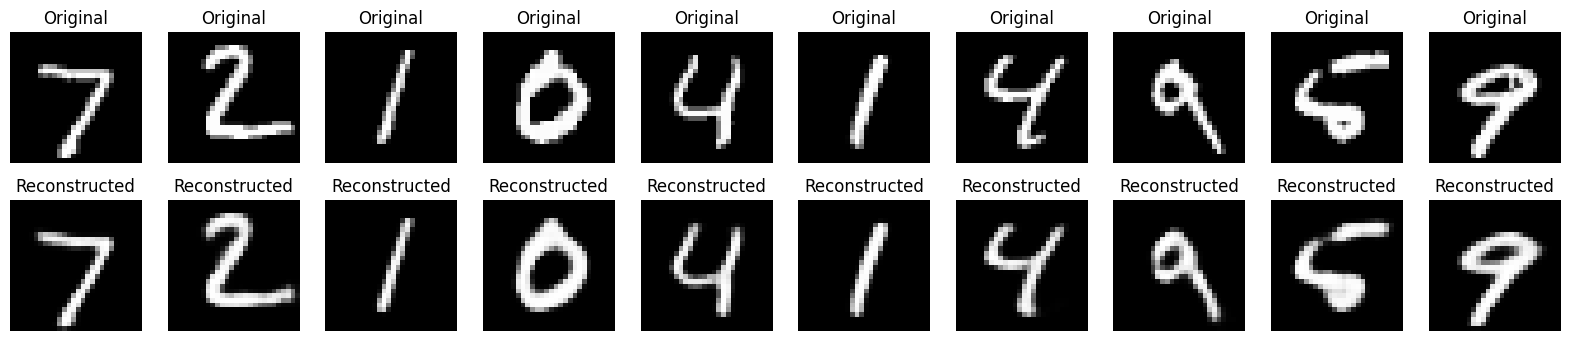

In [5]:
# --- STEP 5: Visualize Reconstruction ---
decoded_imgs = autoencoder.predict(x_test[:10])

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

In [6]:
# --- STEP 6: Use Encoder for Classification ---

# Extract encoded features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

print("Encoded training data shape:", x_train_encoded.shape)

# Classifier model
classifier = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Encoded training data shape: (60000, 64)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,226 (67.29 KB)

 Trainable params: 17,226 (67.29 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# --- STEP 7: Train Classifier on Encoded Data ---
classifier.fit(
    x_train_encoded, y_train,
    epochs=15,
    batch_size=256,
    validation_data=(x_test_encoded, y_test)
)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4756 - loss: 2.5325 - val_accuracy: 0.9222 - val_loss: 0.2738
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8818 - loss: 0.3824 - val_accuracy: 0.9422 - val_loss: 0.1943
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9123 - loss: 0.2812 - val_accuracy: 0.9562 - val_loss: 0.1503
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9278 - loss: 0.2381 - val_accuracy: 0.9592 - val_loss: 0.1341
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9371 - loss: 0.2046 - val_accuracy: 0.9651 - val_loss: 0.1156
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9451 - loss: 0.1814 - val_accuracy: 0.9658 - val_loss: 0.1041
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9486 - loss: 0.1666 - val_accuracy: 0.9679 - val_loss: 0.1020
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9520 - loss: 0.1569 - val_accuracy: 0.

In [8]:
# --- STEP 8: Evaluate ---
test_loss, test_acc = classifier.evaluate(x_test_encoded, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9761


In [9]:
# --- STEP 9: Save Models ---
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")
classifier.save("mnist_autoencoder_classifier.h5")

print("Models saved successfully.")

Models saved successfully.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


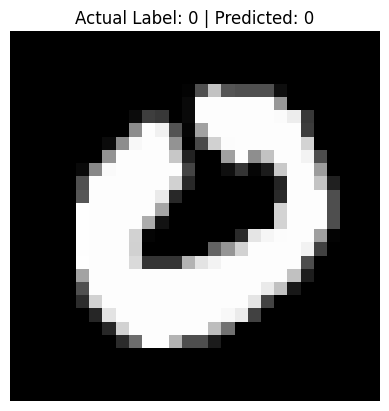

Actual Label: 0
Predicted Label: 0


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Encode the test images using your trained encoder
encoded_test = encoder.predict(x_test)

# Predict digit using your trained classifier
pred = classifier.predict(encoded_test)

# Choose any test image index (you can change this number)
i = 25

# Get predicted and actual label
predicted_label = np.argmax(pred[i])
actual_label = y_test[i]

# Plot the image
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.title(f"Actual Label: {actual_label} | Predicted: {predicted_label}")
plt.axis('off')
plt.show()

# Also print in console
print("Actual Label:", actual_label)
print("Predicted Label:", predicted_label)

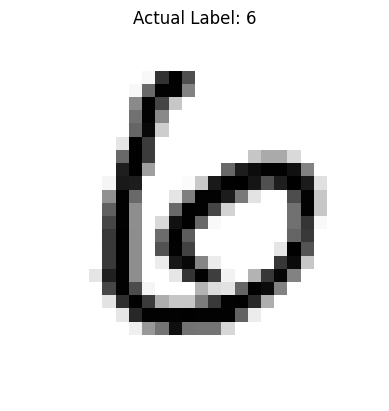

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Label: 6


In [18]:
digit_to_display = 6

# Find the first test sample that is actually that digit
index = np.where(y_test == digit_to_display)[0][0]

plt.imshow(x_test[index].reshape(28, 28), cmap=plt.cm.binary)
plt.title(f"Actual Label: {y_test[index]}")
plt.axis('off') # Add this line to turn off the axis
plt.show()

# Predict that single image
single_image = x_test[index].reshape(1, 28, 28, 1)
# Encode the single image using the encoder model
encoded_single_image = encoder.predict(single_image)
# Use the existing classifier model for prediction
prediction = classifier.predict(encoded_single_image)
predicted_label = np.argmax(prediction)

print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


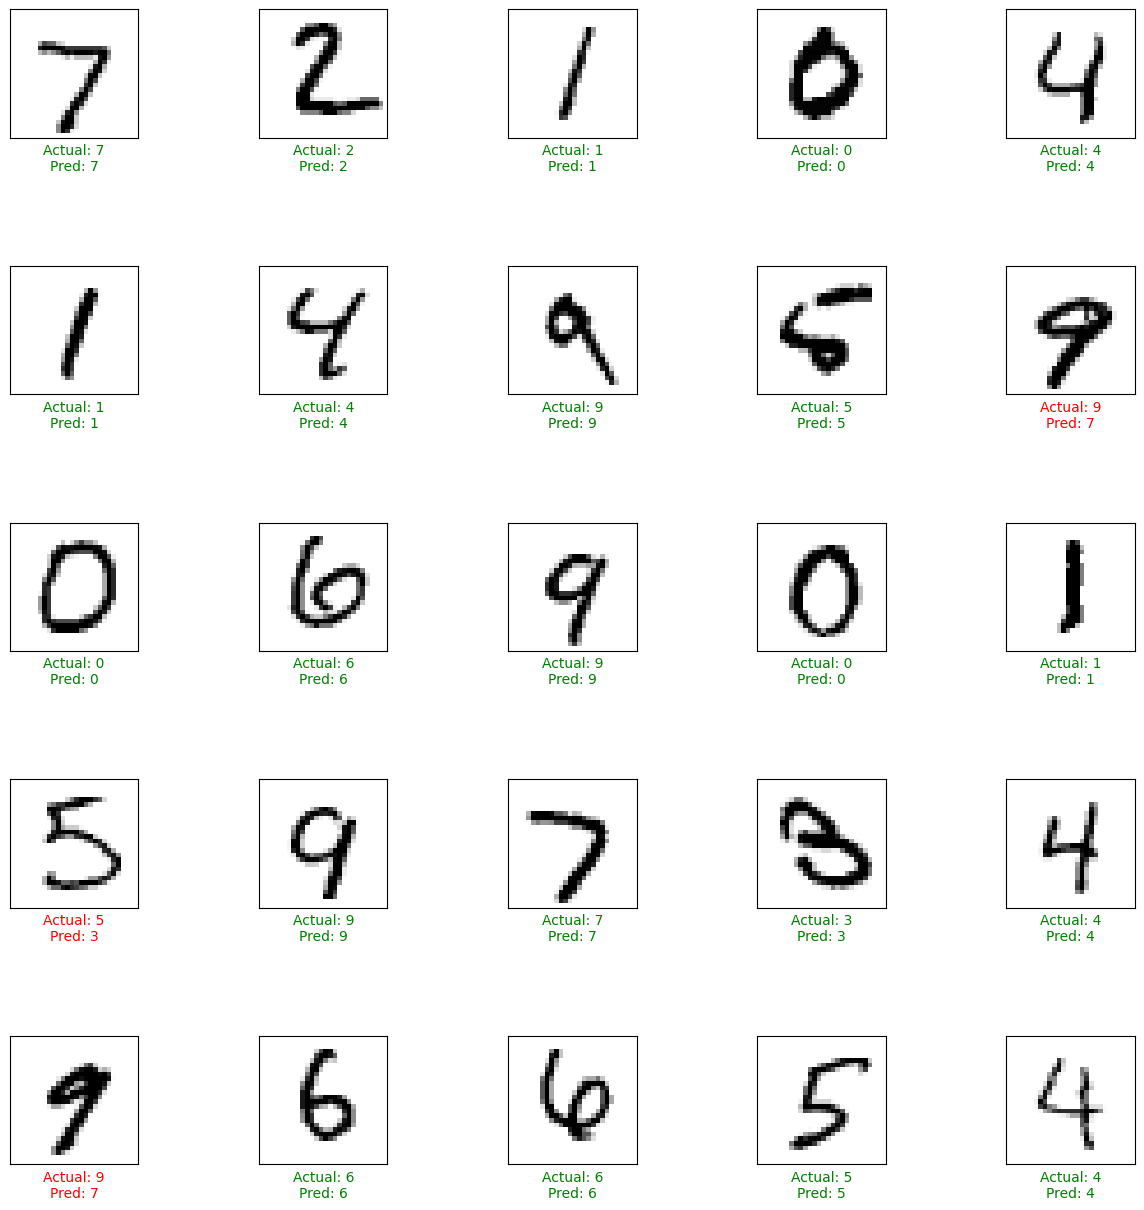

In [29]:
import math
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 10: Visualize Grid Classification ---

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

# Define the number of images to display in the grid
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))

# Create a figure for the grid
plt.figure(figsize=(15, 15))

# Predict digit using your trained classifier on a subset of test images
encoded_test_subset = encoder.predict(x_test[:numbers_to_display])
predictions = classifier.predict(encoded_test_subset)
predicted_labels = np.argmax(predictions, axis=1)

# Loop through the selected images and plot them in the grid
for plot_index in range(numbers_to_display):
    predicted_label = predicted_labels[plot_index]
    actual_label = y_test[plot_index]

    # Create a subplot for each image
    ax = plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Determine the color of the label based on prediction accuracy
    color = 'green' if predicted_label == actual_label else 'red'

    # Display the image
    plt.imshow(x_test[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)

    # Set the label below the image
    ax.set_xlabel(f"Actual: {actual_label}\nPred: {predicted_label}", color=color)


# Adjust spacing between subplots
plt.subplots_adjust(hspace=1.0, wspace=0.5)
plt.show()